# Algoritmo de predição de doenças no coração

As doenças cardiovasculares são uma das principais causadoras de mortes ao redor do mundo, possuindo estimativa de que 17,9 milhões de pessoas acabam morrendo anualmente por decorrência de alguma dessas doenças, segundo a [Organização Mundial de Saúde](https://www.who.int/health-topics/cardiovascular-diseases). A OMS considera as doenças cardiovasculares como um problema grave de saúde pública, sendo recomendado o tratamento preventivo para amenização dos sintomas.

## Objetivo do projeto

A missão principal do projeto é imaginar que somos uma empresa de tecnologia contratados para criar um algoritmo de machine learning capaz de identificar se uma pessoa possui ou não problemas cardiovasculares através de um [conjunto de dados](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) de pacientes que possuem doenças cardiovasculares.


## PARTE 1: Análise exploratória de dados

Começando o projeto, vamos importar as bibliotecas necessárias e da uma olhada preliminar nos dados.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Magic function to display plots in notebook
%matplotlib inline

In [2]:
df = pd.read_csv("heart_disease_prediction.csv")

df.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

Analisando os dados estatísticos do df

In [4]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Existem alguns pontos de atenção, sendo a média de colesterol muito alta, uma vez que buscamos um valor médio proximo de 22 mm. 

Outros pontos importantes é em relação aos valores mínimos de colesterol e pressão sanguínea que estão com o valor zero, o que é um valor impossível de se alcançar.

Conferindo a contagem de cada caractarística do df.

In [5]:
# Obtendo a quantidade de colunas
df.shape

(918, 12)

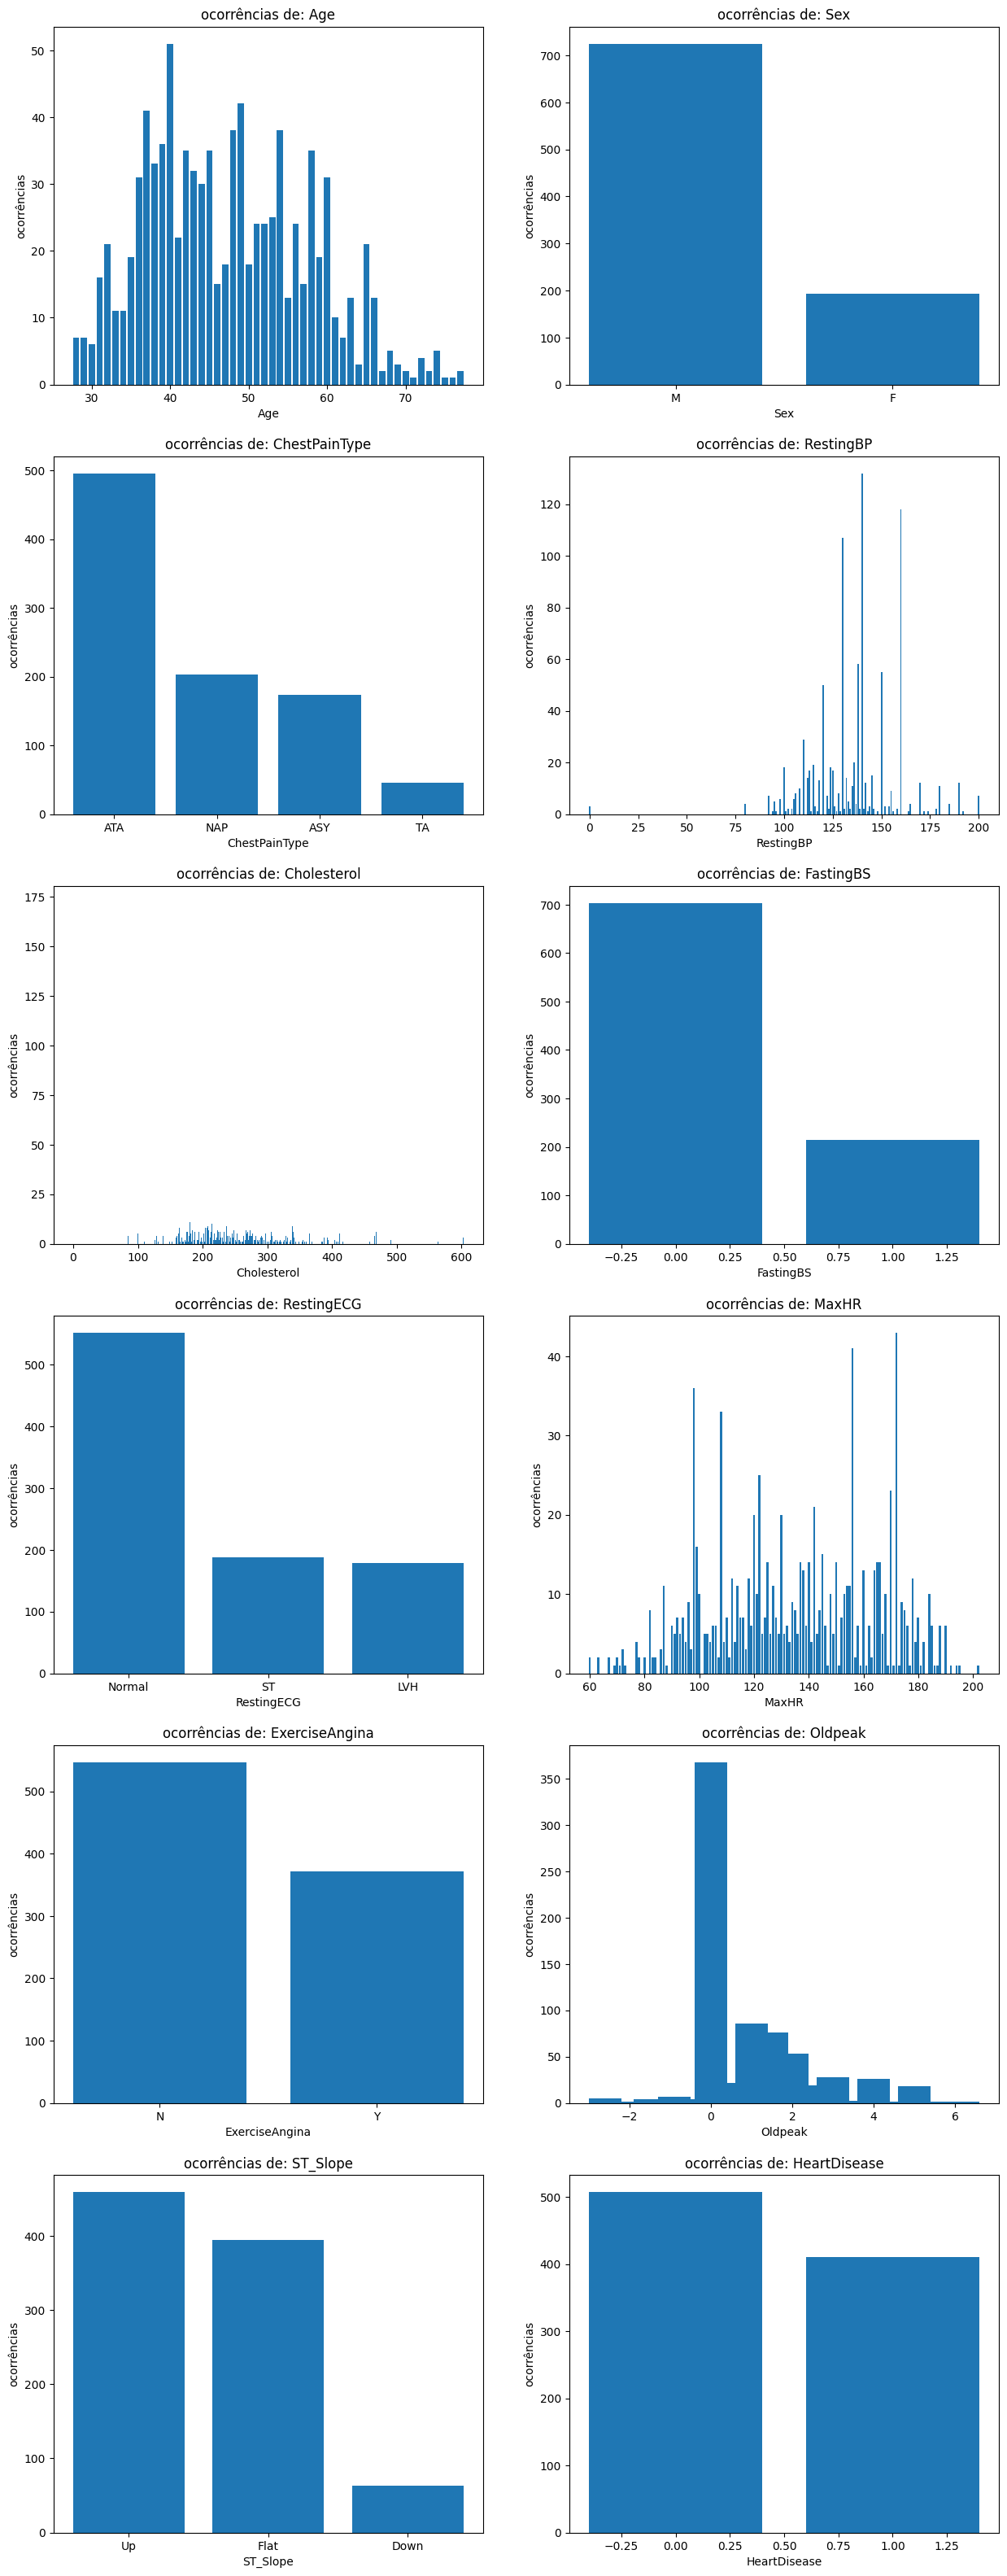

In [6]:
fig = plt.figure(figsize=(15, 40))

features = df.columns

for i, feature in zip(range(1, 13), features):
    unique_values = df[feature].unique()
    count_values = df[feature].value_counts()

    bar = plt.subplot(6, 2, i)
    plt.bar(unique_values, count_values)
    # plt.bar_label(bar.containers[-1])

    plt.title(f"ocorrências de: {feature}")
    plt.xlabel(feature)
    plt.ylabel("ocorrências")


plt.show()

Analisando pontos de interesse:

In [7]:
df["Sex"].value_counts()

M    725
F    193
Name: Sex, dtype: int64

In [8]:
# variável alvo Target
df["HeartDisease"].value_counts()

1    508
0    410
Name: HeartDisease, dtype: int64

In [9]:
# número significativo de pacientes Assintomáticos
valor = df.loc[df["ChestPainType"] == "ASY", "ChestPainType"].value_counts()
valor

ASY    496
Name: ChestPainType, dtype: int64

### Limpando o dataset

No dataset existem alguns valores incoerentes, como comentado anteriormente, sendo eles os valores mínimos de pressão cardíaca e do colesterol que constam como valores zero, vamos observa a quantidade de dados que possuem esse valor para buscar um tratamento adequado.

In [10]:
print(f"número de linhas com valor zero para RestingBP: {(df['RestingBP'] == 0).sum()}")
print(
    f"número de linhas com valor zero para Cholesterol: {(df['Cholesterol'] == 0).sum()}"
)

número de linhas com valor zero para RestingBP: 1
número de linhas com valor zero para Cholesterol: 172


Enquanto RestingBP apresenta apenas um valor incoerente, para o Colesterol existem 172 linhas, caso excluissimos, estariamos perdendo uma grande quantidade de dados.

Vamo tratar o problema substituindo os valores nulos pela média dos casos positivos.

In [11]:
# Criando uma cópia do dataframe original
clean_df = df.copy()

# Entrada de valores 0 em RestingBP com valor médio da coluna agrupada por HeartDisease
clean_df["RestingBP"] = clean_df.groupby("HeartDisease")["RestingBP"].apply(
    lambda x: x.replace(0, x.median())
)

# Entrada de valores 0 em Cholesteral com valor médio da coluna agrupada por HeartDisease
clean_df["Cholesterol"] = clean_df.groupby("HeartDisease")["Cholesterol"].apply(
    lambda x: x.replace(0, x.median())
)

In [12]:
clean_df[["Cholesterol", "RestingBP"]].describe()

,Cholesterol,RestingBP
count,918.000000,918.000000
mean,239.675381,132.540305
std,54.328249,17.989941
min,85.000000,80.000000
25%,214.000000,120.000000
50%,225.000000,130.000000
75%,267.000000,140.000000
max,603.000000,200.000000


## PARTE 2: preparativo do algoritmo de machine learning

Com os dados limpos, podemos dar seguimento para a criação do algoritmo de machine learning, vamos observar quais recursos possuem boa correlação com a variável alvo.

In [13]:
# Transformando as variáveis em variáveis ficticias
clean_df = pd.get_dummies(clean_df, drop_first=True)

Criando um mapa de calor para visualizar melhor a correlação entre as variáveis

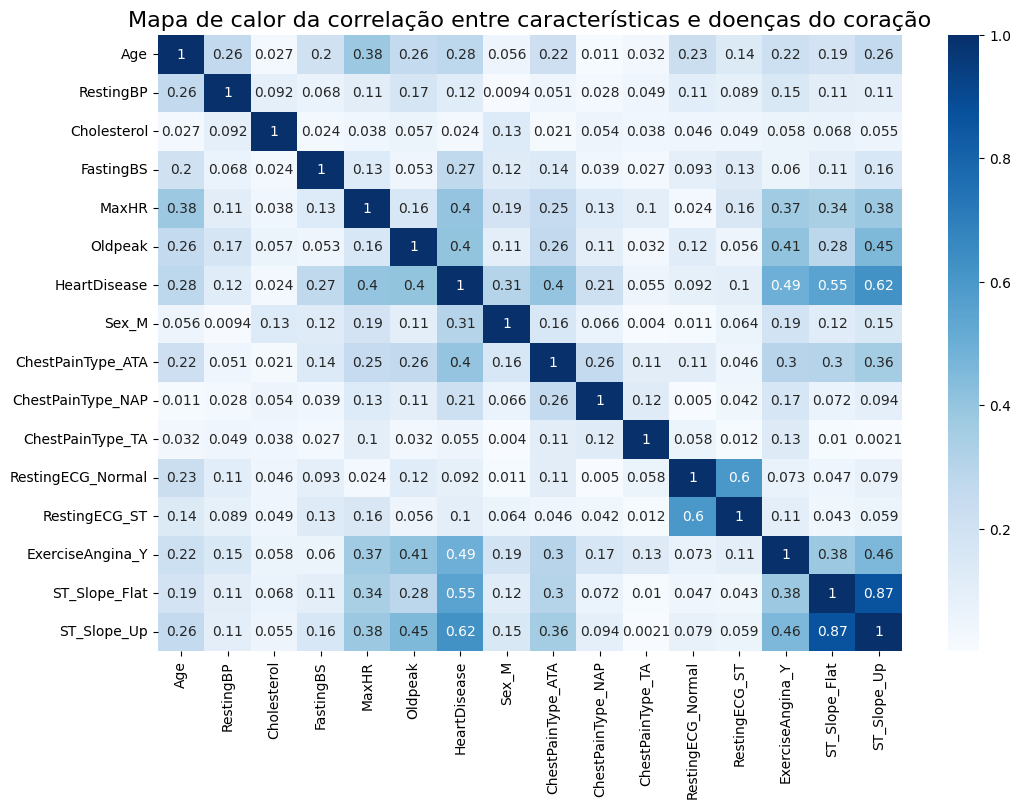

In [14]:
correlation = abs(clean_df.corr())

plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap="Blues")
plt.title(
    "Mapa de calor da correlação entre características e doenças do coração",
    fontsize=16,
)

plt.show()

As características que possuem melhor correlação com as doenças do coração são:
- `Oldpeak`
    - Vale a pena notar que também podemos selecionar `MaxHR` ou `ChestPainType_ATA` como recursos adicionais a serem considerados.
- `Sex_M`
    - Embora tenha um coeficiente de correlação relativamente baixo, decidimos levá-lo em consideração com base em nossas observações de EDA.
- `ExerciseAngina_Y`
- `ST_Slope_Flat`
- `ST_Slope_Up`



## Classificador para um recurso

Vamos preparar o nosso conjunto de treinamento para uma variável. Aproveitando para:
- Testar tamanhos diferentes do conjunto de treinamento
- Testar diferentes recursos para cada conjunto de treinamento

In [15]:
# Limpando a saída de avisos futuros
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

# Conjunto de treinamento
X = clean_df.drop("HeartDisease", axis=1)
y = clean_df["HeartDisease"]

# Features e tamanhos do conjunto de treinamento
recursos = ["Oldpeak", "Sex_M", "ExerciseAngina_Y", "ST_Slope_Flat", "ST_Slope_Up"]
tamanhos = [0.25, 0.20, 0.15, 0.10]

# Lista para armazenar resultados
resultado = []

# Percorrer todos os tamanhos de conjunto de treinamento
for tamanho in tamanhos:
    # Preparando o conjunto de treinamento e testes com diferentes tamanhos
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=tamanho, random_state=42
    )

    # Testando cada recurso para cada tamanho de conjunto com k=3
    for recurso in recursos:
        knn = KNeighborsClassifier(n_neighbors=3)
        knn.fit(X_train[[recurso]], y_train)

        accuracy = knn.score(X_test[[recurso]], y_test)

        precisao = round(accuracy, 4)
        resultado.append([recurso, precisao, tamanho])

resultado

[['Oldpeak', 0.6174, 0.25],
 ['Sex_M', 0.6565, 0.25],
 ['ExerciseAngina_Y', 0.5739, 0.25],
 ['ST_Slope_Flat', 0.7435, 0.25],
 ['ST_Slope_Up', 0.8, 0.25],
 ['Oldpeak', 0.6467, 0.2],
 ['Sex_M', 0.6413, 0.2],
 ['ExerciseAngina_Y', 0.6576, 0.2],
 ['ST_Slope_Flat', 0.75, 0.2],
 ['ST_Slope_Up', 0.7989, 0.2],
 ['Oldpeak', 0.7029, 0.15],
 ['Sex_M', 0.4058, 0.15],
 ['ExerciseAngina_Y', 0.6522, 0.15],
 ['ST_Slope_Flat', 0.7319, 0.15],
 ['ST_Slope_Up', 0.7899, 0.15],
 ['Oldpeak', 0.6848, 0.1],
 ['Sex_M', 0.413, 0.1],
 ['ExerciseAngina_Y', 0.663, 0.1],
 ['ST_Slope_Flat', 0.587, 0.1],
 ['ST_Slope_Up', 0.7935, 0.1]]

Buscando a maior média de precisão para os diferentes tamanhos dos conjuntos de treinamento.

In [16]:
df_res = pd.DataFrame(resultado, columns=["recurso", "precisão", "tamanho"])
df_res.groupby("tamanho")["precisão"].mean()

tamanho
0.10    0.62826
0.15    0.65654
0.20    0.69890
0.25    0.67826
Name: precisão, dtype: float64

Observamos que o melhor tamanho será de 85% de treino e 15% teste, por obtermos uma média de precisão maior.

In [17]:
df_res.groupby("recurso")["precisão"].mean()

recurso
ExerciseAngina_Y    0.636675
Oldpeak             0.662950
ST_Slope_Flat       0.703100
ST_Slope_Up         0.795575
Sex_M               0.529150
Name: precisão, dtype: float64

In [18]:
df_res[df_res["tamanho"] == 0.15]

,recurso,precisão,tamanho
10,Oldpeak,0.7029,0.15
11,Sex_M,0.4058,0.15
12,ExerciseAngina_Y,0.6522,0.15
13,ST_Slope_Flat,0.7319,0.15
14,ST_Slope_Up,0.7899,0.15


O recurso com maior precisão em um conjunto de tamanho fixo é o ST_Slope_Up com 78,99%

## Treinando um classificador para multiplos recursos

In [19]:
recursos = ["Oldpeak", "Sex_M", "ExerciseAngina_Y", "ST_Slope_Flat", "ST_Slope_Up"]

X_train, X_test, y_train, y_test = train_test_split(
    X[recursos], y, test_size=0.15, random_state=42
)

scaler = MinMaxScaler()

X_train_scale = scaler.fit_transform(X_train)

X_test_scale = scaler.fit_transform(X_test)

knn = KNeighborsClassifier()
knn.fit(X_train_scale, y_train)

accuracy = knn.score(X_test_scale, y_test)

accuracy

0.7898550724637681

## Preparando uma malha de hyper parâmetros

In [20]:
recursos = ["Oldpeak", "Sex_M", "ExerciseAngina_Y", "ST_Slope_Flat", "ST_Slope_Up"]

X_train, X_test, y_train, y_test = train_test_split(
    X[recursos], y, test_size=0.15, random_state=42
)

scaler = MinMaxScaler()

X_train_scale = scaler.fit_transform(X_train)

parametros = {
    "n_neighbors": list(range(1, 21)),
    "weights": ["uniform", "distance"],
    "metric": ["minkowski", "manhattan"],
}

knn = KNeighborsClassifier()

knn_grid = GridSearchCV(estimator=knn, param_grid=parametros, scoring="accuracy")

knn_grid.fit(X_train_scale, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [21]:
best_score = knn_grid.best_score_
best_params = knn_grid.best_params_
best_modelos = knn_grid.best_estimator_

print(best_modelos)
print(best_score)
print(best_params)

KNeighborsClassifier(n_neighbors=8)
0.8564102564102564
{'metric': 'minkowski', 'n_neighbors': 8, 'weights': 'uniform'}


## Validando o modelo
Por fim, vamos validar o nosso modelo

In [22]:
X_test_scale = scaler.transform(X_test)

melhor_modelo = knn_grid.best_estimator_

predição = melhor_modelo.predict(X_test_scale)

accuracy = accuracy_score(y_test, predição)
print(accuracy)

0.7463768115942029


## Conclusão

NO fim de nossa análise conseguimos criar uma algoritmo de machine learning para k-vizinhos que estima se uma pessoa terá doenças no coração baseados em determinadas características que possuem boa correlação com doenças no coração.
Em nosso estudo descobrimos quais são essas características e utilizamos ela para treinar o algoritmo.

Além disso, também buscamos os melhores hyperparâmetros para o conjunto estudado aperfeçoando a precisão do algoritmo.

O projeto em si visou treinar os conhecimentos de machine learning e análise de dados, sendo estes contemplados.